# Ungraded Lab: Build a Multi-output Model

In this lab, we'll show how you can build models with more than one output. The dataset we will be working on is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency). It is an Energy Efficiency dataset which uses the bulding features (e.g. wall area, roof area) as inputs and has two outputs: Cooling Load and Heating Load. Let's see how we can build a model to train on this data.

## Imports

In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split

## Utilities

We define a few utilities for data conversion and visualization to make our code more neat.

In [3]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

## Prepare the Data

We download the dataset and format it for training.

In [4]:
# Get the data from UCI dataset
URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx'

# Use pandas excel reader
df = pd.read_excel(URL)
df = df.sample(frac=1).reset_index(drop=True)

# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

## Build the Model

Here is how we'll build the model using the functional syntax. Notice that we can specify a list of outputs (i.e. `[y1_output, y2_output]`) when we instantiate the `Model()` class.

In [5]:
# Define model layers.
input_layer = Input(shape=(len(train .columns),))
first_dense = Dense(units='128', activation='relu')(input_layer)
second_dense = Dense(units='128', activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units='1', name='y1_output')(second_dense)
third_dense = Dense(units='64', activation='relu')(second_dense)

# Y2 output will come via the third dense
y2_output = Dense(units='1', name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          1152        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          16512       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           8256        dense_1[0][0]                    
______________________________________________________________________________________________

## Configure parameters

We specify the optimizer as well as the loss and metrics for each output.

In [6]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(lr=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

## Train the Model

In [6]:
# Train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

Train on 614 samples, validate on 154 samples
Epoch 1/500
614/614 [==============================] - 1s 957us/sample - loss: 239.9432 - y1_output_loss: 113.0909 - y2_output_loss: 124.7311 - y1_output_root_mean_squared_error: 10.6844 - y2_output_root_mean_squared_error: 11.2155 - val_loss: 53.0155 - val_y1_output_loss: 19.4448 - val_y2_output_loss: 33.3309 - val_y1_output_root_mean_squared_error: 4.4158 - val_y2_output_root_mean_squared_error: 5.7893
Epoch 2/500
614/614 [==============================] - 0s 151us/sample - loss: 33.4352 - y1_output_loss: 12.6349 - y2_output_loss: 20.5644 - y1_output_root_mean_squared_error: 3.5693 - y2_output_root_mean_squared_error: 4.5492 - val_loss: 27.2529 - val_y1_output_loss: 13.3313 - val_y2_output_loss: 15.2661 - val_y1_output_root_mean_squared_error: 3.6546 - val_y2_output_root_mean_squared_error: 3.7278
Epoch 3/500
614/614 [==============================] - 0s 132us/sample - loss: 26.6329 - y1_output_loss: 10.2454 - y2_output_loss: 16.5273 - y1

614/614 [==============================] - 0s 154us/sample - loss: 14.7511 - y1_output_loss: 4.5555 - y2_output_loss: 10.1139 - y1_output_root_mean_squared_error: 2.1401 - y2_output_root_mean_squared_error: 3.1892 - val_loss: 15.9283 - val_y1_output_loss: 4.4406 - val_y2_output_loss: 10.9656 - val_y1_output_root_mean_squared_error: 2.1466 - val_y2_output_root_mean_squared_error: 3.3646
Epoch 42/500
614/614 [==============================] - 0s 146us/sample - loss: 7.7721 - y1_output_loss: 2.5943 - y2_output_loss: 5.1152 - y1_output_root_mean_squared_error: 1.6182 - y2_output_root_mean_squared_error: 2.2701 - val_loss: 7.9623 - val_y1_output_loss: 2.9281 - val_y2_output_loss: 5.1334 - val_y1_output_root_mean_squared_error: 1.7384 - val_y2_output_root_mean_squared_error: 2.2227
Epoch 43/500
614/614 [==============================] - 0s 143us/sample - loss: 7.2040 - y1_output_loss: 2.4716 - y2_output_loss: 4.6763 - y1_output_root_mean_squared_error: 1.5768 - y2_output_root_mean_squared_er

Epoch 62/500
614/614 [==============================] - 0s 146us/sample - loss: 5.3264 - y1_output_loss: 1.7445 - y2_output_loss: 3.6456 - y1_output_root_mean_squared_error: 1.3015 - y2_output_root_mean_squared_error: 1.9059 - val_loss: 13.4475 - val_y1_output_loss: 3.8622 - val_y2_output_loss: 9.8633 - val_y1_output_root_mean_squared_error: 1.9859 - val_y2_output_root_mean_squared_error: 3.0828
Epoch 63/500
614/614 [==============================] - 0s 146us/sample - loss: 8.1703 - y1_output_loss: 2.7078 - y2_output_loss: 5.4217 - y1_output_root_mean_squared_error: 1.6515 - y2_output_root_mean_squared_error: 2.3330 - val_loss: 10.2822 - val_y1_output_loss: 2.7603 - val_y2_output_loss: 7.2268 - val_y1_output_root_mean_squared_error: 1.6753 - val_y2_output_root_mean_squared_error: 2.7341
Epoch 64/500
614/614 [==============================] - 0s 141us/sample - loss: 7.1289 - y1_output_loss: 2.1589 - y2_output_loss: 4.9577 - y1_output_root_mean_squared_error: 1.4703 - y2_output_root_mean

Epoch 83/500
614/614 [==============================] - 0s 141us/sample - loss: 4.8938 - y1_output_loss: 1.5679 - y2_output_loss: 3.3070 - y1_output_root_mean_squared_error: 1.2557 - y2_output_root_mean_squared_error: 1.8212 - val_loss: 5.8579 - val_y1_output_loss: 0.8734 - val_y2_output_loss: 5.3173 - val_y1_output_root_mean_squared_error: 0.9483 - val_y2_output_root_mean_squared_error: 2.2268
Epoch 84/500
614/614 [==============================] - 0s 156us/sample - loss: 3.6147 - y1_output_loss: 0.8819 - y2_output_loss: 2.7058 - y1_output_root_mean_squared_error: 0.9401 - y2_output_root_mean_squared_error: 1.6526 - val_loss: 2.9424 - val_y1_output_loss: 0.8332 - val_y2_output_loss: 2.2543 - val_y1_output_root_mean_squared_error: 0.9285 - val_y2_output_root_mean_squared_error: 1.4423
Epoch 85/500
614/614 [==============================] - 0s 137us/sample - loss: 3.2949 - y1_output_loss: 0.8595 - y2_output_loss: 2.4158 - y1_output_root_mean_squared_error: 0.9311 - y2_output_root_mean_s

Epoch 104/500
614/614 [==============================] - 0s 141us/sample - loss: 2.8427 - y1_output_loss: 0.7068 - y2_output_loss: 2.1205 - y1_output_root_mean_squared_error: 0.8431 - y2_output_root_mean_squared_error: 1.4601 - val_loss: 3.5076 - val_y1_output_loss: 0.6172 - val_y2_output_loss: 2.8600 - val_y1_output_root_mean_squared_error: 0.7986 - val_y2_output_root_mean_squared_error: 1.6941
Epoch 105/500
614/614 [==============================] - 0s 138us/sample - loss: 2.2083 - y1_output_loss: 0.6241 - y2_output_loss: 1.5673 - y1_output_root_mean_squared_error: 0.7937 - y2_output_root_mean_squared_error: 1.2563 - val_loss: 2.6898 - val_y1_output_loss: 0.6369 - val_y2_output_loss: 2.1612 - val_y1_output_root_mean_squared_error: 0.8043 - val_y2_output_root_mean_squared_error: 1.4293
Epoch 106/500
614/614 [==============================] - 0s 135us/sample - loss: 2.4932 - y1_output_loss: 0.6255 - y2_output_loss: 1.8652 - y1_output_root_mean_squared_error: 0.7939 - y2_output_root_mea

Epoch 145/500
614/614 [==============================] - 0s 134us/sample - loss: 1.1533 - y1_output_loss: 0.2993 - y2_output_loss: 0.8529 - y1_output_root_mean_squared_error: 0.5441 - y2_output_root_mean_squared_error: 0.9259 - val_loss: 1.6664 - val_y1_output_loss: 0.3440 - val_y2_output_loss: 1.5051 - val_y1_output_root_mean_squared_error: 0.5963 - val_y2_output_root_mean_squared_error: 1.1449
Epoch 146/500
614/614 [==============================] - 0s 138us/sample - loss: 1.9559 - y1_output_loss: 0.4566 - y2_output_loss: 1.5484 - y1_output_root_mean_squared_error: 0.6700 - y2_output_root_mean_squared_error: 1.2276 - val_loss: 5.3054 - val_y1_output_loss: 0.7427 - val_y2_output_loss: 4.4510 - val_y1_output_root_mean_squared_error: 0.8759 - val_y2_output_root_mean_squared_error: 2.1303
Epoch 147/500
614/614 [==============================] - 0s 140us/sample - loss: 1.8639 - y1_output_loss: 0.4426 - y2_output_loss: 1.4150 - y1_output_root_mean_squared_error: 0.6669 - y2_output_root_mea

Epoch 186/500
614/614 [==============================] - 0s 146us/sample - loss: 1.4226 - y1_output_loss: 0.3165 - y2_output_loss: 1.1006 - y1_output_root_mean_squared_error: 0.5632 - y2_output_root_mean_squared_error: 1.0513 - val_loss: 1.3775 - val_y1_output_loss: 0.3337 - val_y2_output_loss: 1.1564 - val_y1_output_root_mean_squared_error: 0.5875 - val_y2_output_root_mean_squared_error: 1.0160
Epoch 187/500
614/614 [==============================] - 0s 142us/sample - loss: 1.7723 - y1_output_loss: 0.5467 - y2_output_loss: 1.2092 - y1_output_root_mean_squared_error: 0.7428 - y2_output_root_mean_squared_error: 1.1048 - val_loss: 1.5542 - val_y1_output_loss: 0.2558 - val_y2_output_loss: 1.4971 - val_y1_output_root_mean_squared_error: 0.5151 - val_y2_output_root_mean_squared_error: 1.1353
Epoch 188/500
614/614 [==============================] - 0s 143us/sample - loss: 1.1444 - y1_output_loss: 0.2668 - y2_output_loss: 0.8691 - y1_output_root_mean_squared_error: 0.5184 - y2_output_root_mea

Epoch 227/500
614/614 [==============================] - 0s 140us/sample - loss: 0.9251 - y1_output_loss: 0.2316 - y2_output_loss: 0.6883 - y1_output_root_mean_squared_error: 0.4816 - y2_output_root_mean_squared_error: 0.8325 - val_loss: 1.0946 - val_y1_output_loss: 0.2023 - val_y2_output_loss: 1.0448 - val_y1_output_root_mean_squared_error: 0.4570 - val_y2_output_root_mean_squared_error: 0.9411
Epoch 228/500
614/614 [==============================] - 0s 133us/sample - loss: 0.7654 - y1_output_loss: 0.1840 - y2_output_loss: 0.5751 - y1_output_root_mean_squared_error: 0.4308 - y2_output_root_mean_squared_error: 0.7614 - val_loss: 1.1846 - val_y1_output_loss: 0.2241 - val_y2_output_loss: 1.1101 - val_y1_output_root_mean_squared_error: 0.4818 - val_y2_output_root_mean_squared_error: 0.9759
Epoch 229/500
614/614 [==============================] - 0s 143us/sample - loss: 1.7297 - y1_output_loss: 0.4473 - y2_output_loss: 1.2743 - y1_output_root_mean_squared_error: 0.6694 - y2_output_root_mea

Epoch 268/500
614/614 [==============================] - 0s 129us/sample - loss: 0.6985 - y1_output_loss: 0.1920 - y2_output_loss: 0.5214 - y1_output_root_mean_squared_error: 0.4376 - y2_output_root_mean_squared_error: 0.7120 - val_loss: 2.4873 - val_y1_output_loss: 0.3639 - val_y2_output_loss: 2.0940 - val_y1_output_root_mean_squared_error: 0.6128 - val_y2_output_root_mean_squared_error: 1.4532
Epoch 269/500
614/614 [==============================] - 0s 137us/sample - loss: 0.9090 - y1_output_loss: 0.2360 - y2_output_loss: 0.6830 - y1_output_root_mean_squared_error: 0.4782 - y2_output_root_mean_squared_error: 0.8249 - val_loss: 1.8348 - val_y1_output_loss: 0.5282 - val_y2_output_loss: 1.4342 - val_y1_output_root_mean_squared_error: 0.7381 - val_y2_output_root_mean_squared_error: 1.1358
Epoch 270/500
614/614 [==============================] - 0s 142us/sample - loss: 0.9606 - y1_output_loss: 0.2687 - y2_output_loss: 0.6857 - y1_output_root_mean_squared_error: 0.5198 - y2_output_root_mea

Epoch 309/500
614/614 [==============================] - 0s 140us/sample - loss: 0.6999 - y1_output_loss: 0.1756 - y2_output_loss: 0.5431 - y1_output_root_mean_squared_error: 0.4199 - y2_output_root_mean_squared_error: 0.7236 - val_loss: 2.2524 - val_y1_output_loss: 0.3687 - val_y2_output_loss: 1.8225 - val_y1_output_root_mean_squared_error: 0.6108 - val_y2_output_root_mean_squared_error: 1.3709
Epoch 310/500
614/614 [==============================] - 0s 141us/sample - loss: 0.9407 - y1_output_loss: 0.2428 - y2_output_loss: 0.6893 - y1_output_root_mean_squared_error: 0.4949 - y2_output_root_mean_squared_error: 0.8341 - val_loss: 1.0173 - val_y1_output_loss: 0.1937 - val_y2_output_loss: 0.9419 - val_y1_output_root_mean_squared_error: 0.4459 - val_y2_output_root_mean_squared_error: 0.9047
Epoch 311/500
614/614 [==============================] - 0s 140us/sample - loss: 0.6113 - y1_output_loss: 0.1766 - y2_output_loss: 0.4322 - y1_output_root_mean_squared_error: 0.4201 - y2_output_root_mea

Epoch 350/500
614/614 [==============================] - 0s 142us/sample - loss: 0.7042 - y1_output_loss: 0.1984 - y2_output_loss: 0.5013 - y1_output_root_mean_squared_error: 0.4460 - y2_output_root_mean_squared_error: 0.7108 - val_loss: 1.0148 - val_y1_output_loss: 0.2616 - val_y2_output_loss: 0.7929 - val_y1_output_root_mean_squared_error: 0.5128 - val_y2_output_root_mean_squared_error: 0.8671
Epoch 351/500
614/614 [==============================] - 0s 139us/sample - loss: 0.5619 - y1_output_loss: 0.1760 - y2_output_loss: 0.3818 - y1_output_root_mean_squared_error: 0.4213 - y2_output_root_mean_squared_error: 0.6200 - val_loss: 0.9751 - val_y1_output_loss: 0.1760 - val_y2_output_loss: 0.9232 - val_y1_output_root_mean_squared_error: 0.4213 - val_y2_output_root_mean_squared_error: 0.8931
Epoch 352/500
614/614 [==============================] - 0s 145us/sample - loss: 0.4308 - y1_output_loss: 0.1436 - y2_output_loss: 0.2891 - y1_output_root_mean_squared_error: 0.3801 - y2_output_root_mea

Epoch 391/500
614/614 [==============================] - 0s 139us/sample - loss: 0.5086 - y1_output_loss: 0.1579 - y2_output_loss: 0.3513 - y1_output_root_mean_squared_error: 0.3953 - y2_output_root_mean_squared_error: 0.5935 - val_loss: 0.7798 - val_y1_output_loss: 0.1626 - val_y2_output_loss: 0.6648 - val_y1_output_root_mean_squared_error: 0.4070 - val_y2_output_root_mean_squared_error: 0.7837
Epoch 392/500
614/614 [==============================] - 0s 143us/sample - loss: 0.6298 - y1_output_loss: 0.1805 - y2_output_loss: 0.4444 - y1_output_root_mean_squared_error: 0.4263 - y2_output_root_mean_squared_error: 0.6694 - val_loss: 0.8055 - val_y1_output_loss: 0.2027 - val_y2_output_loss: 0.6398 - val_y1_output_root_mean_squared_error: 0.4560 - val_y2_output_root_mean_squared_error: 0.7730
Epoch 393/500
614/614 [==============================] - 0s 138us/sample - loss: 0.4292 - y1_output_loss: 0.1361 - y2_output_loss: 0.2911 - y1_output_root_mean_squared_error: 0.3695 - y2_output_root_mea

Epoch 432/500
614/614 [==============================] - 0s 134us/sample - loss: 0.4208 - y1_output_loss: 0.1435 - y2_output_loss: 0.2757 - y1_output_root_mean_squared_error: 0.3793 - y2_output_root_mean_squared_error: 0.5262 - val_loss: 0.7894 - val_y1_output_loss: 0.1693 - val_y2_output_loss: 0.6812 - val_y1_output_root_mean_squared_error: 0.4157 - val_y2_output_root_mean_squared_error: 0.7853
Epoch 433/500
614/614 [==============================] - 0s 143us/sample - loss: 0.4240 - y1_output_loss: 0.1312 - y2_output_loss: 0.3001 - y1_output_root_mean_squared_error: 0.3592 - y2_output_root_mean_squared_error: 0.5432 - val_loss: 1.2253 - val_y1_output_loss: 0.3244 - val_y2_output_loss: 0.9005 - val_y1_output_root_mean_squared_error: 0.5777 - val_y2_output_root_mean_squared_error: 0.9442
Epoch 434/500
614/614 [==============================] - 0s 142us/sample - loss: 0.5619 - y1_output_loss: 0.1934 - y2_output_loss: 0.3663 - y1_output_root_mean_squared_error: 0.4416 - y2_output_root_mea

Epoch 473/500
614/614 [==============================] - 0s 142us/sample - loss: 0.3778 - y1_output_loss: 0.1331 - y2_output_loss: 0.2426 - y1_output_root_mean_squared_error: 0.3661 - y2_output_root_mean_squared_error: 0.4938 - val_loss: 0.8969 - val_y1_output_loss: 0.1469 - val_y2_output_loss: 0.8260 - val_y1_output_root_mean_squared_error: 0.3858 - val_y2_output_root_mean_squared_error: 0.8649
Epoch 474/500
614/614 [==============================] - 0s 134us/sample - loss: 0.3337 - y1_output_loss: 0.1211 - y2_output_loss: 0.2119 - y1_output_root_mean_squared_error: 0.3490 - y2_output_root_mean_squared_error: 0.4603 - val_loss: 0.8640 - val_y1_output_loss: 0.1739 - val_y2_output_loss: 0.7117 - val_y1_output_root_mean_squared_error: 0.4215 - val_y2_output_root_mean_squared_error: 0.8285
Epoch 475/500
614/614 [==============================] - 0s 136us/sample - loss: 0.4061 - y1_output_loss: 0.1344 - y2_output_loss: 0.2697 - y1_output_root_mean_squared_error: 0.3681 - y2_output_root_mea

## Evaluate the Model and Plot Metrics

In [7]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

154/154 [==============================] - 0s 491us/sample - loss: 0.7702 - y1_output_loss: 0.1988 - y2_output_loss: 0.5975 - y1_output_root_mean_squared_error: 0.4394 - y2_output_root_mean_squared_error: 0.7597
Loss = 0.7702314915595116, Y1_loss = 0.1988246738910675, Y1_mse = 0.4393978714942932, Y2_loss = 0.5974723100662231, Y2_mse = 0.7597111463546753


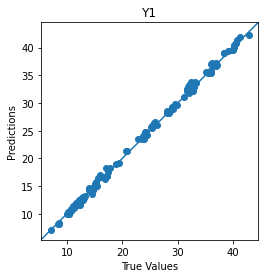

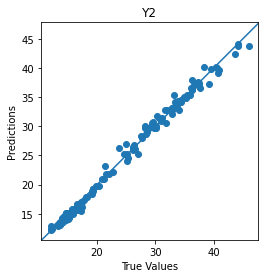

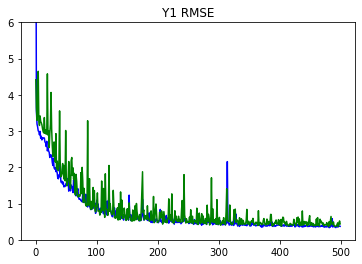

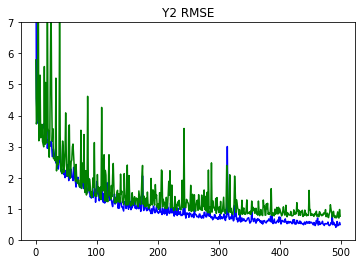

In [8]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)